PPP (with BM3D) Fan-Beam CT Reconstruction
==========================================

This example demonstrates solution of a fan-beam tomographic reconstruction
problem using the Plug-and-Play Priors framework
<cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR
<cite data-cite="svmbir-2020"/> for tomographic projection.

This example uses the data fidelity term as one of the ADMM $g$
functionals so that the optimization with respect to the data fidelity is
able to exploit the internal prox of the `SVMBIRExtendedLoss` functional.

We solve the problem in two different ways:
1. Approximating the fan-beam geometry using parallel-beam and using the
   parallel beam projector to compute the reconstruction.
2. Using the correct fan-beam geometry to perform a reconstruction.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import svmbir
from matplotlib.ticker import MaxNLocator
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D
from scico.linop import Diagonal, Identity
from scico.linop.xray.svmbir import SVMBIRExtendedLoss, XRayTransform
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
pad_len = 5
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 2 * pad_len)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, pad_len)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram for fan beam and parallel beam.
For fan beam, use view angles spanning 2π since unlike parallel beam, views
at 0 and π are not equivalent.

In [3]:
num_angles = int(N / 2)
num_channels = N

# Use angles in the range [0, 2*pi] for fan beam
angles = snp.linspace(0, 2 * snp.pi, num_angles, endpoint=False, dtype=snp.float32)

dist_source_detector = 1500.0
magnification = 1.2
A_fan = XRayTransform(
    x_gt.shape,
    angles,
    num_channels,
    geometry="fan-curved",
    dist_source_detector=dist_source_detector,
    magnification=magnification,
)
A_parallel = XRayTransform(
    x_gt.shape,
    angles,
    num_channels,
    geometry="parallel",
)

sino_fan = A_fan @ x_gt

Impose Poisson noise on sinograms. Higher max_intensity means less noise.

In [4]:
def add_poisson_noise(sino, max_intensity):
    expected_counts = max_intensity * np.exp(-sino)
    noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
    noisy_counts[noisy_counts == 0] = 1  # deal with 0s
    y = -np.log(noisy_counts / max_intensity)

    return y


y_fan = add_poisson_noise(sino_fan, max_intensity=500)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights_fan = svmbir.calc_weights(y_fan, weight_type="transmission")

x_mrf_fan = svmbir.recon(
    np.array(y_fan[:, np.newaxis]),
    np.array(angles),
    weights=weights_fan[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
    stop_threshold=0.0,
    geometry="fan-curved",
    dist_source_detector=dist_source_detector,
    magnification=magnification,
    delta_channel=1.0,
    delta_pixel=1.0 / magnification,
)[0]

x_mrf_parallel = svmbir.recon(
    np.array(y_fan[:, np.newaxis]),
    np.array(angles),
    weights=weights_fan[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
    stop_threshold=0.0,
    geometry="parallel",
)[0]

Convert numpy arrays to jax arrays.

In [6]:
y_fan = snp.array(y_fan)
x0_fan = snp.array(x_mrf_fan)
weights_fan = snp.array(weights_fan)
x0_parallel = snp.array(x_mrf_parallel)

Set problem parameters and BM3D pseudo-functional.

In [7]:
ρ = 10  # ADMM penalty parameter
σ = density * 0.6  # denoiser sigma
g0 = σ * ρ * BM3D()

Set up problem using `SVMBIRExtendedLoss`.

In [8]:
f_extloss_fan = SVMBIRExtendedLoss(
    y=y_fan,
    A=A_fan,
    W=Diagonal(weights_fan),
    scale=0.5,
    positivity=True,
    prox_kwargs={"maxiter": 5, "ctol": 0.0},
)
f_extloss_parallel = SVMBIRExtendedLoss(
    y=y_fan,
    A=A_parallel,
    W=Diagonal(weights_fan),
    scale=0.5,
    positivity=True,
    prox_kwargs={"maxiter": 5, "ctol": 0.0},
)

solver_extloss_fan = ADMM(
    f=None,
    g_list=[f_extloss_fan, g0],
    C_list=[Identity(x_mrf_fan.shape), Identity(x_mrf_fan.shape)],
    rho_list=[ρ, ρ],
    x0=x0_fan,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True, "period": 5},
)
solver_extloss_parallel = ADMM(
    f=None,
    g_list=[f_extloss_parallel, g0],
    C_list=[Identity(x_mrf_parallel.shape), Identity(x_mrf_parallel.shape)],
    rho_list=[ρ, ρ],
    x0=x0_parallel,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True, "period": 5},
)

Run the ADMM solvers.

In [9]:
print(f"Solving on {device_info()}\n")
x_extloss_fan = solver_extloss_fan.solve()
hist_extloss_fan = solver_extloss_fan.itstat_object.history(transpose=True)

print()
x_extloss_parallel = solver_extloss_parallel.solve()
hist_extloss_parallel = solver_extloss_parallel.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  6.88e+00  8.865e-01  8.865e-01      0  0.000e+00


   1  9.44e+00  6.943e-01  3.838e-01      1  9.519e-09


   2  1.19e+01  3.495e-01  3.879e-01      1  1.239e-08


   3  1.43e+01  2.191e-01  2.719e-01      1  8.123e-10


   4  1.67e+01  1.810e-01  1.481e-01      1  3.975e-10


   5  1.92e+01  1.390e-01  8.493e-02      1  1.266e-09


   6  2.18e+01  9.887e-02  6.994e-02      1  1.273e-09


   7  2.41e+01  7.586e-02  5.608e-02      1  1.038e-09


   8  2.66e+01  6.502e-02  4.128e-02      1  1.100e-10


   9  2.92e+01  5.666e-02  3.281e-02      1  8.976e-11


  10  3.16e+01  4.964e-02  2.756e-02      1  5.139e-10


  11  3.41e+01  4.433e-02  2.377e-02      1  6.149e-11


  12  3.65e+01  4.080e-02  2.171e-02      1  4.371e-11


  13  3.88e+01  3.781e-02  2.003e-02      1  3.604e-10


  14  4.11e+01  3.512e-02  1.841e-02      1  3.400e-10


  15  4.34e+01  3.282e-02  1.722e-02      1  3.136e-10


  16  4.58e+01  3.139e-02  1.690e-02      1  3.863e-11


  17  4.83e+01  2.949e-02  1.578e-02      1  2.991e-10


  18  5.08e+01  2.795e-02  1.488e-02      1  2.782e-10


  19  5.32e+01  2.668e-02  1.425e-02      1  2.637e-10



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  6.23e+00  7.442e-01  7.442e-01      0  0.000e+00


   1  8.69e+00  6.180e-01  2.615e-01      1  3.104e-09


   2  1.11e+01  3.762e-01  2.657e-01      1  7.340e-09


   3  1.36e+01  2.636e-01  2.006e-01      1  6.166e-09


   4  1.59e+01  1.999e-01  1.326e-01      1  3.391e-09


   5  1.85e+01  1.556e-01  8.944e-02      1  2.917e-10


   6  2.08e+01  1.248e-01  6.762e-02      1  2.359e-10


   7  2.32e+01  1.040e-01  5.404e-02      1  1.898e-10


   8  2.55e+01  8.830e-02  4.546e-02      1  9.372e-10


   9  2.78e+01  7.563e-02  4.032e-02      1  8.470e-10


  10  3.01e+01  6.701e-02  3.646e-02      1  7.718e-10


  11  3.26e+01  6.024e-02  3.227e-02      1  8.596e-11


  12  3.51e+01  5.416e-02  3.039e-02      1  7.016e-11


  13  3.77e+01  4.891e-02  2.665e-02      1  6.526e-10


  14  4.01e+01  4.583e-02  2.691e-02      1  5.686e-10


  15  4.26e+01  4.356e-02  2.635e-02      1  5.898e-10


  16  4.49e+01  4.099e-02  2.528e-02      1  6.065e-11


  17  4.72e+01  3.869e-02  2.385e-02      1  4.731e-11


  18  4.94e+01  3.685e-02  2.332e-02      1  4.333e-11


  19  5.18e+01  3.558e-02  2.301e-02      1  7.958e-10


Show the recovered images. The parallel beam reconstruction is poor because
the parallel beam is a poor approximation of the specific fan beam geometry
used here.

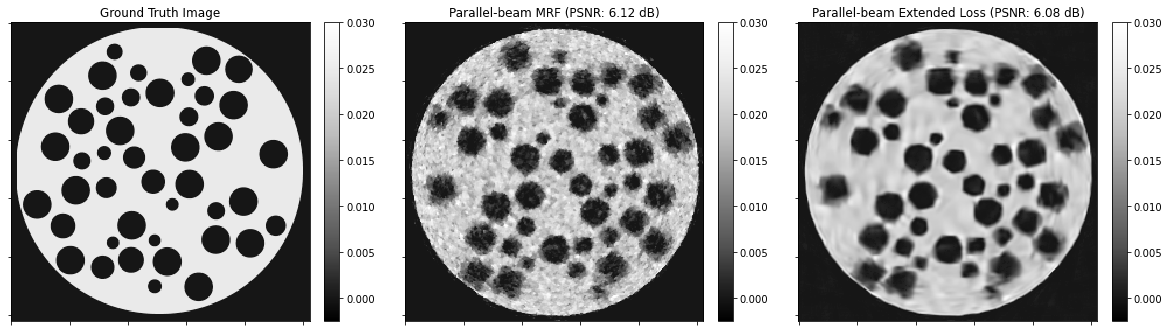

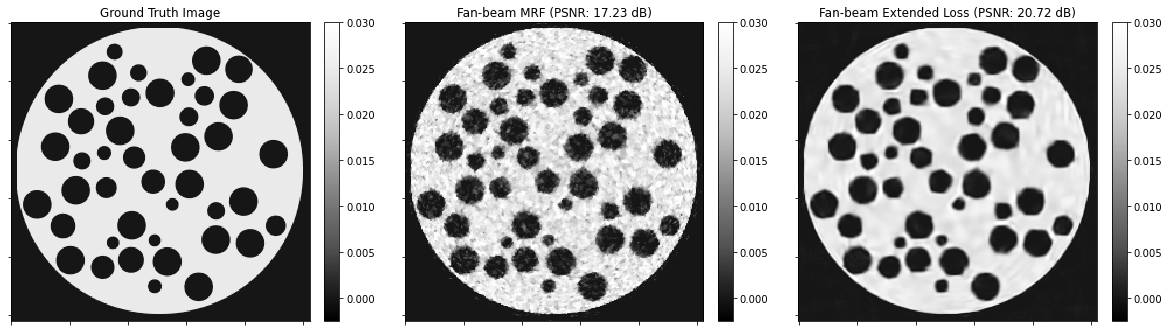

In [10]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf_parallel,
    title=f"Parallel-beam MRF (PSNR: {metric.psnr(x_gt, x_mrf_parallel):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_extloss_parallel,
    title=f"Parallel-beam Extended Loss (PSNR: {metric.psnr(x_gt, x_extloss_parallel):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()


fig, ax = plt.subplots(1, 3, figsize=(20, 7))
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf_fan,
    title=f"Fan-beam MRF (PSNR: {metric.psnr(x_gt, x_mrf_fan):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_extloss_fan,
    title=f"Fan-beam Extended Loss (PSNR: {metric.psnr(x_gt, x_extloss_fan):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

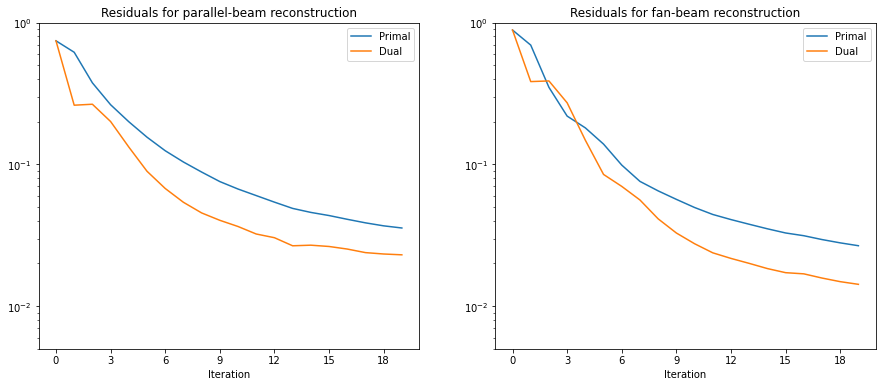

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot.plot(
    snp.vstack((hist_extloss_parallel.Prml_Rsdl, hist_extloss_parallel.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals for parallel-beam reconstruction",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[0],
)
ax[0].set_ylim([5e-3, 5e0])
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
plot.plot(
    snp.vstack((hist_extloss_fan.Prml_Rsdl, hist_extloss_fan.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals for fan-beam reconstruction",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
ax[1].set_ylim([5e-3, 5e0])
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
fig.show()